In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from scipy.ndimage import gaussian_filter

In [2]:
import sys
sys.path.append('../')
from utils.datasets import *
from utils.data_augmentation import *

## Dataset pixel values distribution 

In [3]:
data_augmentation = "none"
img_size, crop_size = 224, 224 # We will take original image not transformed one
mask_reshape_method = "padd"
train_aug, train_aug_img, val_aug = data_augmentation_selector(
    data_augmentation, img_size, crop_size, mask_reshape_method
)

Using None Data Augmentation
Padding masks!
Padding masks!


In [4]:
add_depth = False
normalization = "none"
batch_size = 100

train_dataset = LVSC2Dataset(
    mode="train", transform=train_aug, img_transform=train_aug_img,
    add_depth=add_depth, normalization=normalization, relative_path="../"
)
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, pin_memory=True,
    shuffle=False, collate_fn=train_dataset.custom_collate
)

In [5]:
imgs_values = np.empty(0)
for batch_indx, batch in enumerate(train_loader):
    for original_img in batch["original_img"]:
        imgs_values = np.append(imgs_values, original_img.flatten())
    break  # We cannot accumulate in this way the values, out of memory...

In [6]:
imgs_values.shape

(6361088,)

Text(0.5, 1.0, 'Distribution of MRI pixel values')

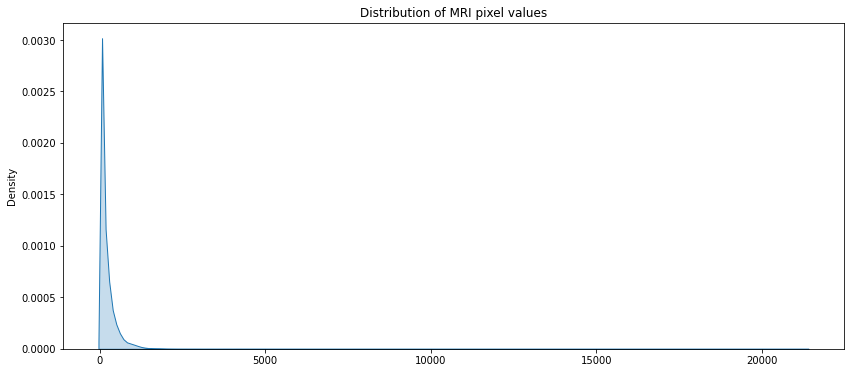

In [7]:
# Set the width and height of the figure
plt.figure(figsize=(14,6))

# KDE plots for each species
sns.kdeplot(imgs_values, shade=True)

# Add title
plt.title("Distribution of MRI pixel values")

## Masks Spatial Priors (distribution)

In [8]:
train_masks = []
for batch_indx, batch in enumerate(train_loader):
    train_masks.append(batch["label"])

In [9]:
train_masks = torch.cat(train_masks)
train_masks.shape

torch.Size([24723, 1, 224, 224])

In [10]:
# We can perform train_masks.sum() because class labels are 1 to count numer of pixels
mask_spatial_frecs = (torch.sum(train_masks, dim=0) / train_masks.sum())
mask_spatial_frecs.shape

torch.Size([1, 224, 224])

In [11]:
mask_sp = mask_spatial_frecs.squeeze(0)
print(f"[Original mask prior] Max frec: {mask_sp.max()}")
print(f"[Original mask prior] Min frec: {mask_sp.min()}")
mask_sp_normalized = (mask_sp / mask_sp.max())
print(f"[Normalized mask prior] Max frec: {mask_sp_normalized.max()}")
print(f"[Normalized mask prior] Min frec: {mask_sp_normalized.min()}")

[Original mask prior] Max frec: 0.0004394499119371176
[Original mask prior] Min frec: 0.0
[Normalized mask prior] Max frec: 1.0
[Normalized mask prior] Min frec: 0.0


Text(0.5, 1.0, 'Train Masks Spatial Prior')

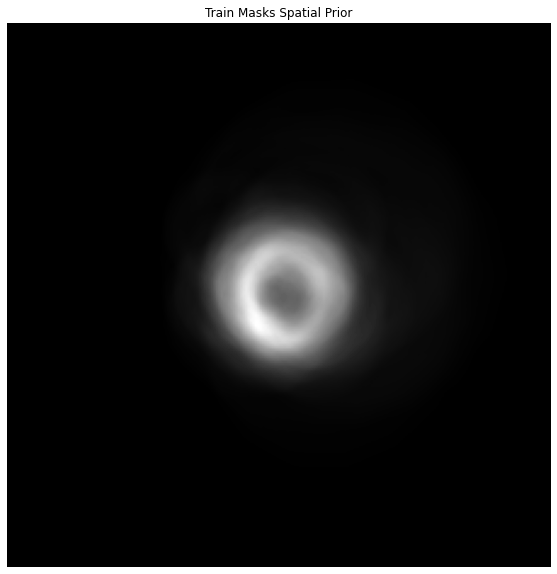

In [12]:
# Set the width and height of the figure
plt.figure(figsize=(10,10))
plt.imshow(mask_sp_normalized, cmap="gray")
plt.axis("off")
plt.title("Train Masks Spatial Prior")

In [13]:
sigma = 2
window_size = 70
truncate = (((window_size - 1)/2)-0.5)/sigma

mask_sp_normalized_gaussian = gaussian_filter(
    mask_sp_normalized, sigma=sigma, truncate=truncate
)

print(f"[Gaussian mask prior] Max frec: {mask_sp_normalized_gaussian.max()}")
print(f"[Gaussian mask prior] Min frec: {mask_sp_normalized_gaussian.min()}")

[Gaussian mask prior] Max frec: 0.9537089467048645
[Gaussian mask prior] Min frec: 0.0


Text(0.5, 1.0, 'Train Masks Spatial Prior Gaussian Blur')

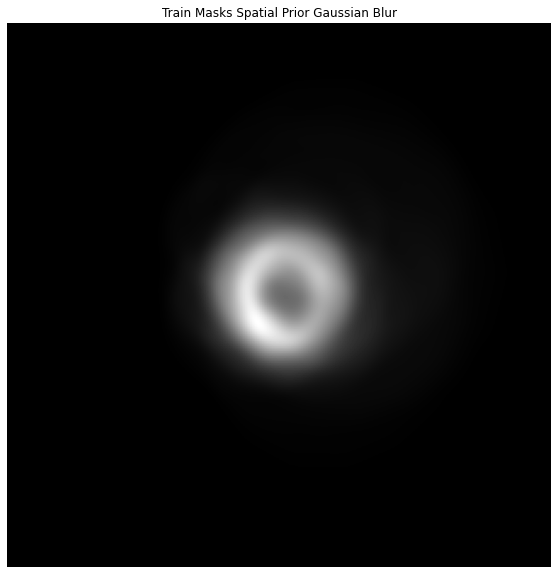

In [14]:
# Set the width and height of the figure
plt.figure(figsize=(10,10))
plt.imshow(mask_sp_normalized_gaussian, cmap="gray")
plt.axis("off")
plt.title("Train Masks Spatial Prior Gaussian Blur")

Should we add a smooth value to non 0s?